# CMU Panoptic Dataset

http://domedb.perception.cs.cmu.edu/

In [1]:
# ---- settings ----
import json
from pprint import pprint
Settings = json.load(open('../../settings.txt'))
print('Settings:')
pprint(Settings)
print('\n')
# ------------------
from os.path import join, isdir

data_path = join(Settings['data_root'], 'cmu_panoptic')

# check if the directory exists
assert isdir(data_path), "The CMU panoptic data root MUST exist"

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

Settings:
{'CMU': {'data_root': '/storage/DATA/cmu_panoptic'},
 'UMPM': {'password': 'ahJaka4o', 'username': 'umpmuser'},
 'data_root': '/storage/DATA/'}




## Ultimatum1

Get the data as follows:

Go to the data directory for cmu-panoptic (data-root must be set in the settings.txt):
```bash
cd /data-root/cmu_panoptic
```

there download the data:
```bash
./getData.sh 160422_ultimatum1 10 0
```

and then extract the video images:
```bash
./extractAll.sh.sh 160422_ultimatum1
```

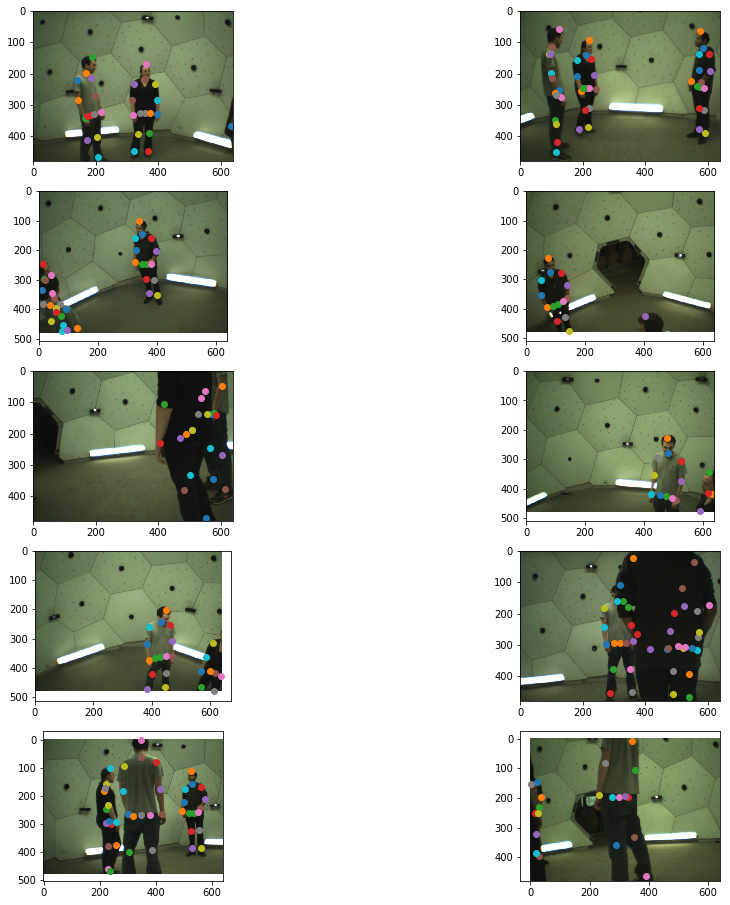

In [7]:
seq_name = '160422_ultimatum1'
seq_dir = join(data_path, seq_name)

# check if the directory exists
assert isdir(seq_dir), "The sequence " + seq_name + " does not exist!"

vga_skel_json_path = join(seq_dir, 'vgaPose3d_stage1')
vga_img_path = join(seq_dir, 'vgaImgs')


with open(join(seq_dir, 'calibration_{0}.json'.format(seq_name))) as cfile:
    calib = json.load(cfile)

# Cameras are identified by a tuple of (panel#,node#)
cameras = {(cam['panel'],cam['node']):cam for cam in calib['cameras']}

# Convert data into numpy arrays for convenience
for k,cam in cameras.items():    
    cam['K'] = np.matrix(cam['K'])
    cam['distCoef'] = np.array(cam['distCoef'])
    cam['R'] = np.matrix(cam['R'])
    cam['t'] = np.array(cam['t']).reshape((3,1))
    
#panels = [1, 6, 14, 16, 19]
#nodes = [1, 15, 3, 12, 14]
panels = [1, 5, 6, 9, 10, 14, 15, 16, 18, 19]
nodes = [1, 8, 15, 12, 6, 3, 12, 12, 13, 14]
cams = zip(panels, nodes)

sel_cameras = [cameras[cam].copy() for cam in cams]


idx = 2000  # 250
fig = plt.figure(figsize=(16,16))
for icam, cam in enumerate(sel_cameras):
    image_path = vga_img_path+'/{0:02d}_{1:02d}/{0:02d}_{1:02d}_{2:08d}.jpg'.format(cam['panel'], cam['node'], idx)
    im = plt.imread(image_path)
    
    h,w,_ = im.shape
    
    ax = fig.add_subplot(np.ceil(len(nodes)/2),2,icam+1)
    ax.imshow(im)
    
    K = cam['K']
    R = cv2.Rodrigues(cam['R'])[0]
    t = cam['t']
    distCoef = cam['distCoef']

        
    try:
        skel_json_fname = vga_skel_json_path+'/body3DScene_{0:08d}.json'.format(idx)
        with open(skel_json_fname) as dfile:
            bframe = json.load(dfile)
            
            for body in bframe['bodies']:
                pid = body['id']
                skel = np.array(body['joints15']).reshape((-1,4))
                
                points3d = skel[:,0:3]
                
                points3d = np.array([points3d])
                
                points2d,_ = cv2.projectPoints(points3d, R, t, K, distCoef)
                points2d = np.squeeze(points2d)
                for x,y in points2d:
                    if y > 0 and y < h and x > 0 and x < w:
                        ax.scatter(x, y)
                
            
    except IOError as e:
        print('Error reading {0}\n'.format(skel_json_fname)+e.strerror)